In [145]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# For financial data retrieval
import pandas_datareader.data as web

# For date handling
from datetime import datetime

# For sentiment analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

from alpha_vantage.timeseries import TimeSeries
from fredapi import Fred
from newsapi import NewsApiClient
import requests
import matplotlib.pyplot as plt

import ta  # Technical Analysis library
from sklearn.model_selection import train_test_split

import math
import seaborn as sns
import networkx as nx

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

import random

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)


In [5]:
# # Initialize Alpha Vantage API
# api_key_alpha = 'E6DCENI7HUDGSZRV'  # Replace with your Alpha Vantage API key
# ts = TimeSeries(key=api_key_alpha, output_format='pandas')

# # Fetch daily data for S&P 500 ETF (e.g., SPY)
# sp500_data, meta_data = ts.get_daily(symbol='SPY', outputsize='full')

# # Reset index to make 'Date' a column
# sp500_data.reset_index(inplace=True)

# # Rename columns to match previous code
# sp500_data.rename(columns={
#     'date': 'Date',
#     '1. open': 'Open',
#     '2. high': 'High',
#     '3. low': 'Low',
#     '4. close': 'Close',
#     '5. volume': 'Volume'
# }, inplace=True)

# # Convert 'Date' to datetime
# sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])

In [2]:
sp500_data = pd.read_csv('sp500_data.csv')
sp500_data

Date      Open      High       Low     Close      Volume
0     2024-11-26  598.8000  601.3300  598.0700  600.6500  45621288.0
1     2024-11-25  599.5200  600.8600  595.2000  597.5300  42441393.0
2     2024-11-22  593.6600  596.1500  593.1525  595.5100  38226390.0
3     2024-11-21  593.4000  595.1200  587.4500  593.6700  46750285.0
4     2024-11-20  590.3800  590.7900  584.6300  590.5000  50032576.0
...          ...       ...       ...       ...       ...         ...
6304  1999-11-05  138.6250  139.1093  136.7812  137.8750   7431500.0
6305  1999-11-04  136.7500  137.3593  135.7656  136.5312   7907500.0
6306  1999-11-03  136.0000  136.3750  135.1250  135.5000   7222300.0
6307  1999-11-02  135.9687  137.2500  134.5937  134.5937   6516900.0
6308  1999-11-01  136.5000  137.0000  135.5625  135.5625   4006500.0

[6309 rows x 6 columns]

In [3]:
# Initialize FRED API
fred = Fred(api_key='a6d8760ec5aac045396d0e0b7039aec7')

# Define series IDs and their corresponding indicators
series_dict = {
    'DCOILWTICO': 'Crude Oil WTI Futures',
    'DFF': 'Federal Funds Rate',
    'DEXUSEU': 'USD/EUR Exchange Rate',
    'DEXUSUK': 'USD/GBP Exchange Rate',
    'DEXCHUS': 'USD/CHF Exchange Rate',
    'DEXNOUS': 'USD/NOK Exchange Rate',
    'DEXSIUS': 'USD/SGD Exchange Rate',
    'DEXUSAL': 'USD/AUD Exchange Rate',
    'DEXCHUS': 'USD/CNY Exchange Rate',
    'DEXJPUS': 'USD/JPY Exchange Rate',
    'DEXINUS': 'USD/INR Exchange Rate',
}

# Set observation period
start_date = '1999-11-01'
end_date = '2024-11-01'

# Initialize an empty DataFrame to store the data
data_frames = []

# Fetch each series separately and store in the list
for series_id, series_name in series_dict.items():
    try:
        # Fetch series
        series_data = fred.get_series(series_id, observation_start=start_date, observation_end=end_date)
        
        # Convert to DataFrame and rename column
        series_df = series_data.to_frame(name=series_name)
        
        # Append to list
        data_frames.append(series_df)
    except Exception as e:
        print(f"Error fetching {series_name} ({series_id}): {e}")

# Concatenate all data frames on the date index
fred_df = pd.concat(data_frames, axis=1)

# Reset index to include the date as a column
fred_df = fred_df.reset_index().rename(columns={'index': 'Date'})

# Display the DataFrame
fred_df


Date  Crude Oil WTI Futures  Federal Funds Rate  \
0    1999-11-01                  22.44                5.38   
1    1999-11-02                  22.49                5.18   
2    1999-11-03                  22.59                5.21   
3    1999-11-04                  23.17                5.27   
4    1999-11-05                  22.93                5.14   
...         ...                    ...                 ...   
9128 2024-10-28                  67.65                4.83   
9129 2024-10-29                  67.48                4.83   
9130 2024-10-30                  68.91                4.83   
9131 2024-10-31                  69.58                4.83   
9132 2024-11-01                  69.81                4.83   

      USD/EUR Exchange Rate  USD/GBP Exchange Rate  USD/CNY Exchange Rate  \
0                    1.0494                 1.6404                 8.2779   
1                    1.0506                 1.6445                 8.2781   
2                    1.0485                 1.6440                 8.2781   
3                    1.0440                 1.6375                 8.2780   
4                    1.0400                 1.6205                 8.2779   
...                     ...                    ...                    ...   
9128                 1.0819                 1.2981                 7.1254   
9129                 1.0798                 1.3005                 7.1301   
9130                 1.0864                 1.3012                 7.1229   
9131                 1.0855                 1.2856                 7.1178   
9132                 1.0848                 1.2959                 7.1214   

      USD/NOK Exchange Rate  USD/SGD Exchange Rate  USD/AUD Exchange Rate  \
0                    7.8770                 1.6565                 0.6382   
1                    7.8650                 1.6645                 0.6405   
2                    7.8825                 1.6700                 0.6437   
3                    7.9120                 1.6665                 0.6383   
4                    7.9260                 1.6715                 0.6385   
...                     ...                    ...                    ...   
9128                10.9866                 1.3227                 0.6587   
9129                10.9651                 1.3254                 0.6557   
9130                10.9397                 1.3222                 0.6584   
9131                11.0315                 1.3230                 0.6550   
9132                11.0471                 1.3242                 0.6582   

      USD/JPY Exchange Rate  USD/INR Exchange Rate  
0                    104.19                  43.51  
1                    104.15                  43.45  
2                    105.00                  43.46  
3                    104.48                  43.45  
4                    106.33                  43.45  
...                     ...                    ...  
9128                 153.21                  84.05  
9129                 153.47                  84.04  
9130                 153.15                  84.07  
9131                 152.35                  84.06  
9132                 152.94                  84.03  

[9133 rows x 11 columns]

In [4]:
# Initialize FRED API
fred2 = Fred(api_key='a6d8760ec5aac045396d0e0b7039aec7')

# Define series IDs and their corresponding indicators
series_dict = {
    'M1SL': 'M1 Money Supply',
    'M2SL': 'M2 Money Supply',
    'CPIAUCSL': 'Consumer Price Index (CPI)',
    'PPIACO': 'Producer Price Index (PPI)',
    'UNRATE': 'Unemployment Rate'
}

# Set observation period
start_date = '1999-11-01'
end_date = '2024-11-01'

# Initialize an empty DataFrame to store the data
data_frames = []

# Fetch each series separately and store in the list
for series_id, series_name in series_dict.items():
    try:
        # Fetch series
        series_data = fred2.get_series(series_id, observation_start=start_date, observation_end=end_date)
        
        # Convert to DataFrame and rename column
        series_df = series_data.to_frame(name=series_name)
        
        # Append to list
        data_frames.append(series_df)
    except Exception as e:
        print(f"Error fetching {series_name} ({series_id}): {e}")

# Concatenate all data frames on the date index
fred_df2 = pd.concat(data_frames, axis=1)

# Reset index to include the date as a column
fred_df2 = fred_df2.reset_index().rename(columns={'index': 'Date'})

# Display the DataFrame
fred_df2


Date  M1 Money Supply  M2 Money Supply  Consumer Price Index (CPI)  \
0   1999-11-01           1110.7           4611.8                     168.400   
1   1999-12-01           1122.2           4639.3                     168.800   
2   2000-01-01           1122.1           4667.6                     169.300   
3   2000-02-01           1108.6           4680.9                     170.000   
4   2000-03-01           1107.5           4711.7                     171.000   
..         ...              ...              ...                         ...   
295 2024-06-01          18045.2          21020.1                     313.049   
296 2024-07-01          18031.8          21039.4                     313.534   
297 2024-08-01          18094.5          21141.3                     314.121   
298 2024-09-01          18152.6          21222.7                     314.686   
299 2024-10-01          18237.4          21311.2                     315.454   

     Producer Price Index (PPI)  Unemployment Rate  
0                       128.300                4.1  
1                       127.800                4.0  
2                       128.300                4.0  
3                       129.800                4.1  
4                       130.800                4.0  
..                          ...                ...  
295                     255.914                4.1  
296                     257.326                4.3  
297                     255.394                4.2  
298                     252.737                4.1  
299                     253.452                4.1  

[300 rows x 6 columns]

In [5]:
# Ensure 'Date' columns are in datetime format
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
fred_df['Date'] = pd.to_datetime(fred_df['Date'])
fred_df2['Date'] = pd.to_datetime(fred_df2['Date'])

# Merge the tables on the 'Date' column
# Perform an outer join to preserve all dates across datasets
combined_df = pd.merge(sp500_data, fred_df, on='Date', how='outer')
combined_df = pd.merge(combined_df, fred_df2, on='Date', how='outer')

# Sort by 'Date' to ensure proper time-series alignment
combined_df.sort_values(by='Date', inplace=True)

# Reset the index for convenience
combined_df.reset_index(drop=True, inplace=True)

# Check data types
print("Data Types of Combined DataFrame:")
print(combined_df.dtypes)

# Display the first few rows of the combined dataset
combined_df.head()


Data Types of Combined DataFrame:
Date                          datetime64[ns]
Open                                 float64
High                                 float64
Low                                  float64
Close                                float64
Volume                               float64
Crude Oil WTI Futures                float64
Federal Funds Rate                   float64
USD/EUR Exchange Rate                float64
USD/GBP Exchange Rate                float64
USD/CNY Exchange Rate                float64
USD/NOK Exchange Rate                float64
USD/SGD Exchange Rate                float64
USD/AUD Exchange Rate                float64
USD/JPY Exchange Rate                float64
USD/INR Exchange Rate                float64
M1 Money Supply                      float64
M2 Money Supply                      float64
Consumer Price Index (CPI)           float64
Producer Price Index (PPI)           float64
Unemployment Rate                    float64
dtype: object


Date      Open      High       Low     Close     Volume  \
0 1999-11-01  136.5000  137.0000  135.5625  135.5625  4006500.0   
1 1999-11-02  135.9687  137.2500  134.5937  134.5937  6516900.0   
2 1999-11-03  136.0000  136.3750  135.1250  135.5000  7222300.0   
3 1999-11-04  136.7500  137.3593  135.7656  136.5312  7907500.0   
4 1999-11-05  138.6250  139.1093  136.7812  137.8750  7431500.0   

   Crude Oil WTI Futures  Federal Funds Rate  USD/EUR Exchange Rate  \
0                  22.44                5.38                 1.0494   
1                  22.49                5.18                 1.0506   
2                  22.59                5.21                 1.0485   
3                  23.17                5.27                 1.0440   
4                  22.93                5.14                 1.0400   

   USD/GBP Exchange Rate  ...  USD/NOK Exchange Rate  USD/SGD Exchange Rate  \
0                 1.6404  ...                 7.8770                 1.6565   
1                 1.6445  ...                 7.8650                 1.6645   
2                 1.6440  ...                 7.8825                 1.6700   
3                 1.6375  ...                 7.9120                 1.6665   
4                 1.6205  ...                 7.9260                 1.6715   

   USD/AUD Exchange Rate  USD/JPY Exchange Rate  USD/INR Exchange Rate  \
0                 0.6382                 104.19                  43.51   
1                 0.6405                 104.15                  43.45   
2                 0.6437                 105.00                  43.46   
3                 0.6383                 104.48                  43.45   
4                 0.6385                 106.33                  43.45   

   M1 Money Supply  M2 Money Supply  Consumer Price Index (CPI)  \
0           1110.7           4611.8                       168.4   
1              NaN              NaN                         NaN   
2              NaN              NaN                         NaN   
3              NaN              NaN                         NaN   
4              NaN              NaN                         NaN   

   Producer Price Index (PPI)  Unemployment Rate  
0                       128.3                4.1  
1                         NaN                NaN  
2                         NaN                NaN  
3                         NaN                NaN  
4                         NaN                NaN  

[5 rows x 21 columns]

In [6]:
# Step 1: Check for duplicate dates in the combined dataset
duplicate_dates = combined_df[combined_df.duplicated(subset='Date', keep=False)]
if duplicate_dates.empty:
    print("No duplicate dates found after merging.")
else:
    print(f"Duplicate dates found:\n{duplicate_dates}")

# Step 2: Check for missing values after the merge
missing_summary = combined_df.isnull().sum()
print("\nMissing Value Summary (per column):")
print(missing_summary)

# Step 3: Count rows with missing values in any column
rows_with_missing = combined_df[combined_df.isnull().any(axis=1)]
print(f"\nNumber of rows with missing values: {len(rows_with_missing)}")

# Step 4: Validate row counts
print(f"\nOriginal row counts:")
print(f"sp500_data: {len(sp500_data)}")
print(f"fred_df: {len(fred_df)}")
print(f"fred_df2: {len(fred_df2)}")
print(f"Combined DataFrame: {len(combined_df)}")

# Step 5: Check for unmatched dates in each dataset
sp500_unmatched = sp500_data[~sp500_data['Date'].isin(combined_df['Date'])]
fred_unmatched = fred_df[~fred_df['Date'].isin(combined_df['Date'])]
fred2_unmatched = fred_df2[~fred_df2['Date'].isin(combined_df['Date'])]

print(f"\nUnmatched dates in sp500_data: {len(sp500_unmatched)}")
print(f"Unmatched dates in fred_df: {len(fred_unmatched)}")
print(f"Unmatched dates in fred_df2: {len(fred2_unmatched)}")


No duplicate dates found after merging.

Missing Value Summary (per column):
Date                             0
Open                          2841
High                          2841
Low                           2841
Close                         2841
Volume                        2841
Crude Oil WTI Futures         2876
Federal Funds Rate              17
USD/EUR Exchange Rate         2878
USD/GBP Exchange Rate         2878
USD/CNY Exchange Rate         2877
USD/NOK Exchange Rate         2878
USD/SGD Exchange Rate         2878
USD/AUD Exchange Rate         2878
USD/JPY Exchange Rate         2878
USD/INR Exchange Rate         2879
M1 Money Supply               8850
M2 Money Supply               8850
Consumer Price Index (CPI)    8850
Producer Price Index (PPI)    8850
Unemployment Rate             8850
dtype: int64

Number of rows with missing values: 8955

Original row counts:
sp500_data: 6309
fred_df: 9133
fred_df2: 300
Combined DataFrame: 9150

Unmatched dates in sp500_data: 0
Unmatch

In [7]:
combined_df

Date      Open      High       Low     Close      Volume  \
0    1999-11-01  136.5000  137.0000  135.5625  135.5625   4006500.0   
1    1999-11-02  135.9687  137.2500  134.5937  134.5937   6516900.0   
2    1999-11-03  136.0000  136.3750  135.1250  135.5000   7222300.0   
3    1999-11-04  136.7500  137.3593  135.7656  136.5312   7907500.0   
4    1999-11-05  138.6250  139.1093  136.7812  137.8750   7431500.0   
...         ...       ...       ...       ...       ...         ...   
9145 2024-11-20  590.3800  590.7900  584.6300  590.5000  50032576.0   
9146 2024-11-21  593.4000  595.1200  587.4500  593.6700  46750285.0   
9147 2024-11-22  593.6600  596.1500  593.1525  595.5100  38226390.0   
9148 2024-11-25  599.5200  600.8600  595.2000  597.5300  42441393.0   
9149 2024-11-26  598.8000  601.3300  598.0700  600.6500  45621288.0   

      Crude Oil WTI Futures  Federal Funds Rate  USD/EUR Exchange Rate  \
0                     22.44                5.38                 1.0494   
1                     22.49                5.18                 1.0506   
2                     22.59                5.21                 1.0485   
3                     23.17                5.27                 1.0440   
4                     22.93                5.14                 1.0400   
...                     ...                 ...                    ...   
9145                    NaN                 NaN                    NaN   
9146                    NaN                 NaN                    NaN   
9147                    NaN                 NaN                    NaN   
9148                    NaN                 NaN                    NaN   
9149                    NaN                 NaN                    NaN   

      USD/GBP Exchange Rate  ...  USD/NOK Exchange Rate  \
0                    1.6404  ...                 7.8770   
1                    1.6445  ...                 7.8650   
2                    1.6440  ...                 7.8825   
3                    1.6375  ...                 7.9120   
4                    1.6205  ...                 7.9260   
...                     ...  ...                    ...   
9145                    NaN  ...                    NaN   
9146                    NaN  ...                    NaN   
9147                    NaN  ...                    NaN   
9148                    NaN  ...                    NaN   
9149                    NaN  ...                    NaN   

      USD/SGD Exchange Rate  USD/AUD Exchange Rate  USD/JPY Exchange Rate  \
0                    1.6565                 0.6382                 104.19   
1                    1.6645                 0.6405                 104.15   
2                    1.6700                 0.6437                 105.00   
3                    1.6665                 0.6383                 104.48   
4                    1.6715                 0.6385                 106.33   
...                     ...                    ...                    ...   
9145                    NaN                    NaN                    NaN   
9146                    NaN                    NaN                    NaN   
9147                    NaN                    NaN                    NaN   
9148                    NaN                    NaN                    NaN   
9149                    NaN                    NaN                    NaN   

      USD/INR Exchange Rate  M1 Money Supply  M2 Money Supply  \
0                     43.51           1110.7           4611.8   
1                     43.45              NaN              NaN   
2                     43.46              NaN              NaN   
3                     43.45              NaN              NaN   
4                     43.45              NaN              NaN   
...                     ...              ...              ...   
9145                    NaN              NaN              NaN   
9146                    NaN              NaN              NaN   
9147                    NaN              NaN      

In [ ]:
# Impute monthly data using forward fill
combined_df2 = combined_df.copy()
for column in combined_df.columns:
    combined_df[column] = combined_df[column].ffill()


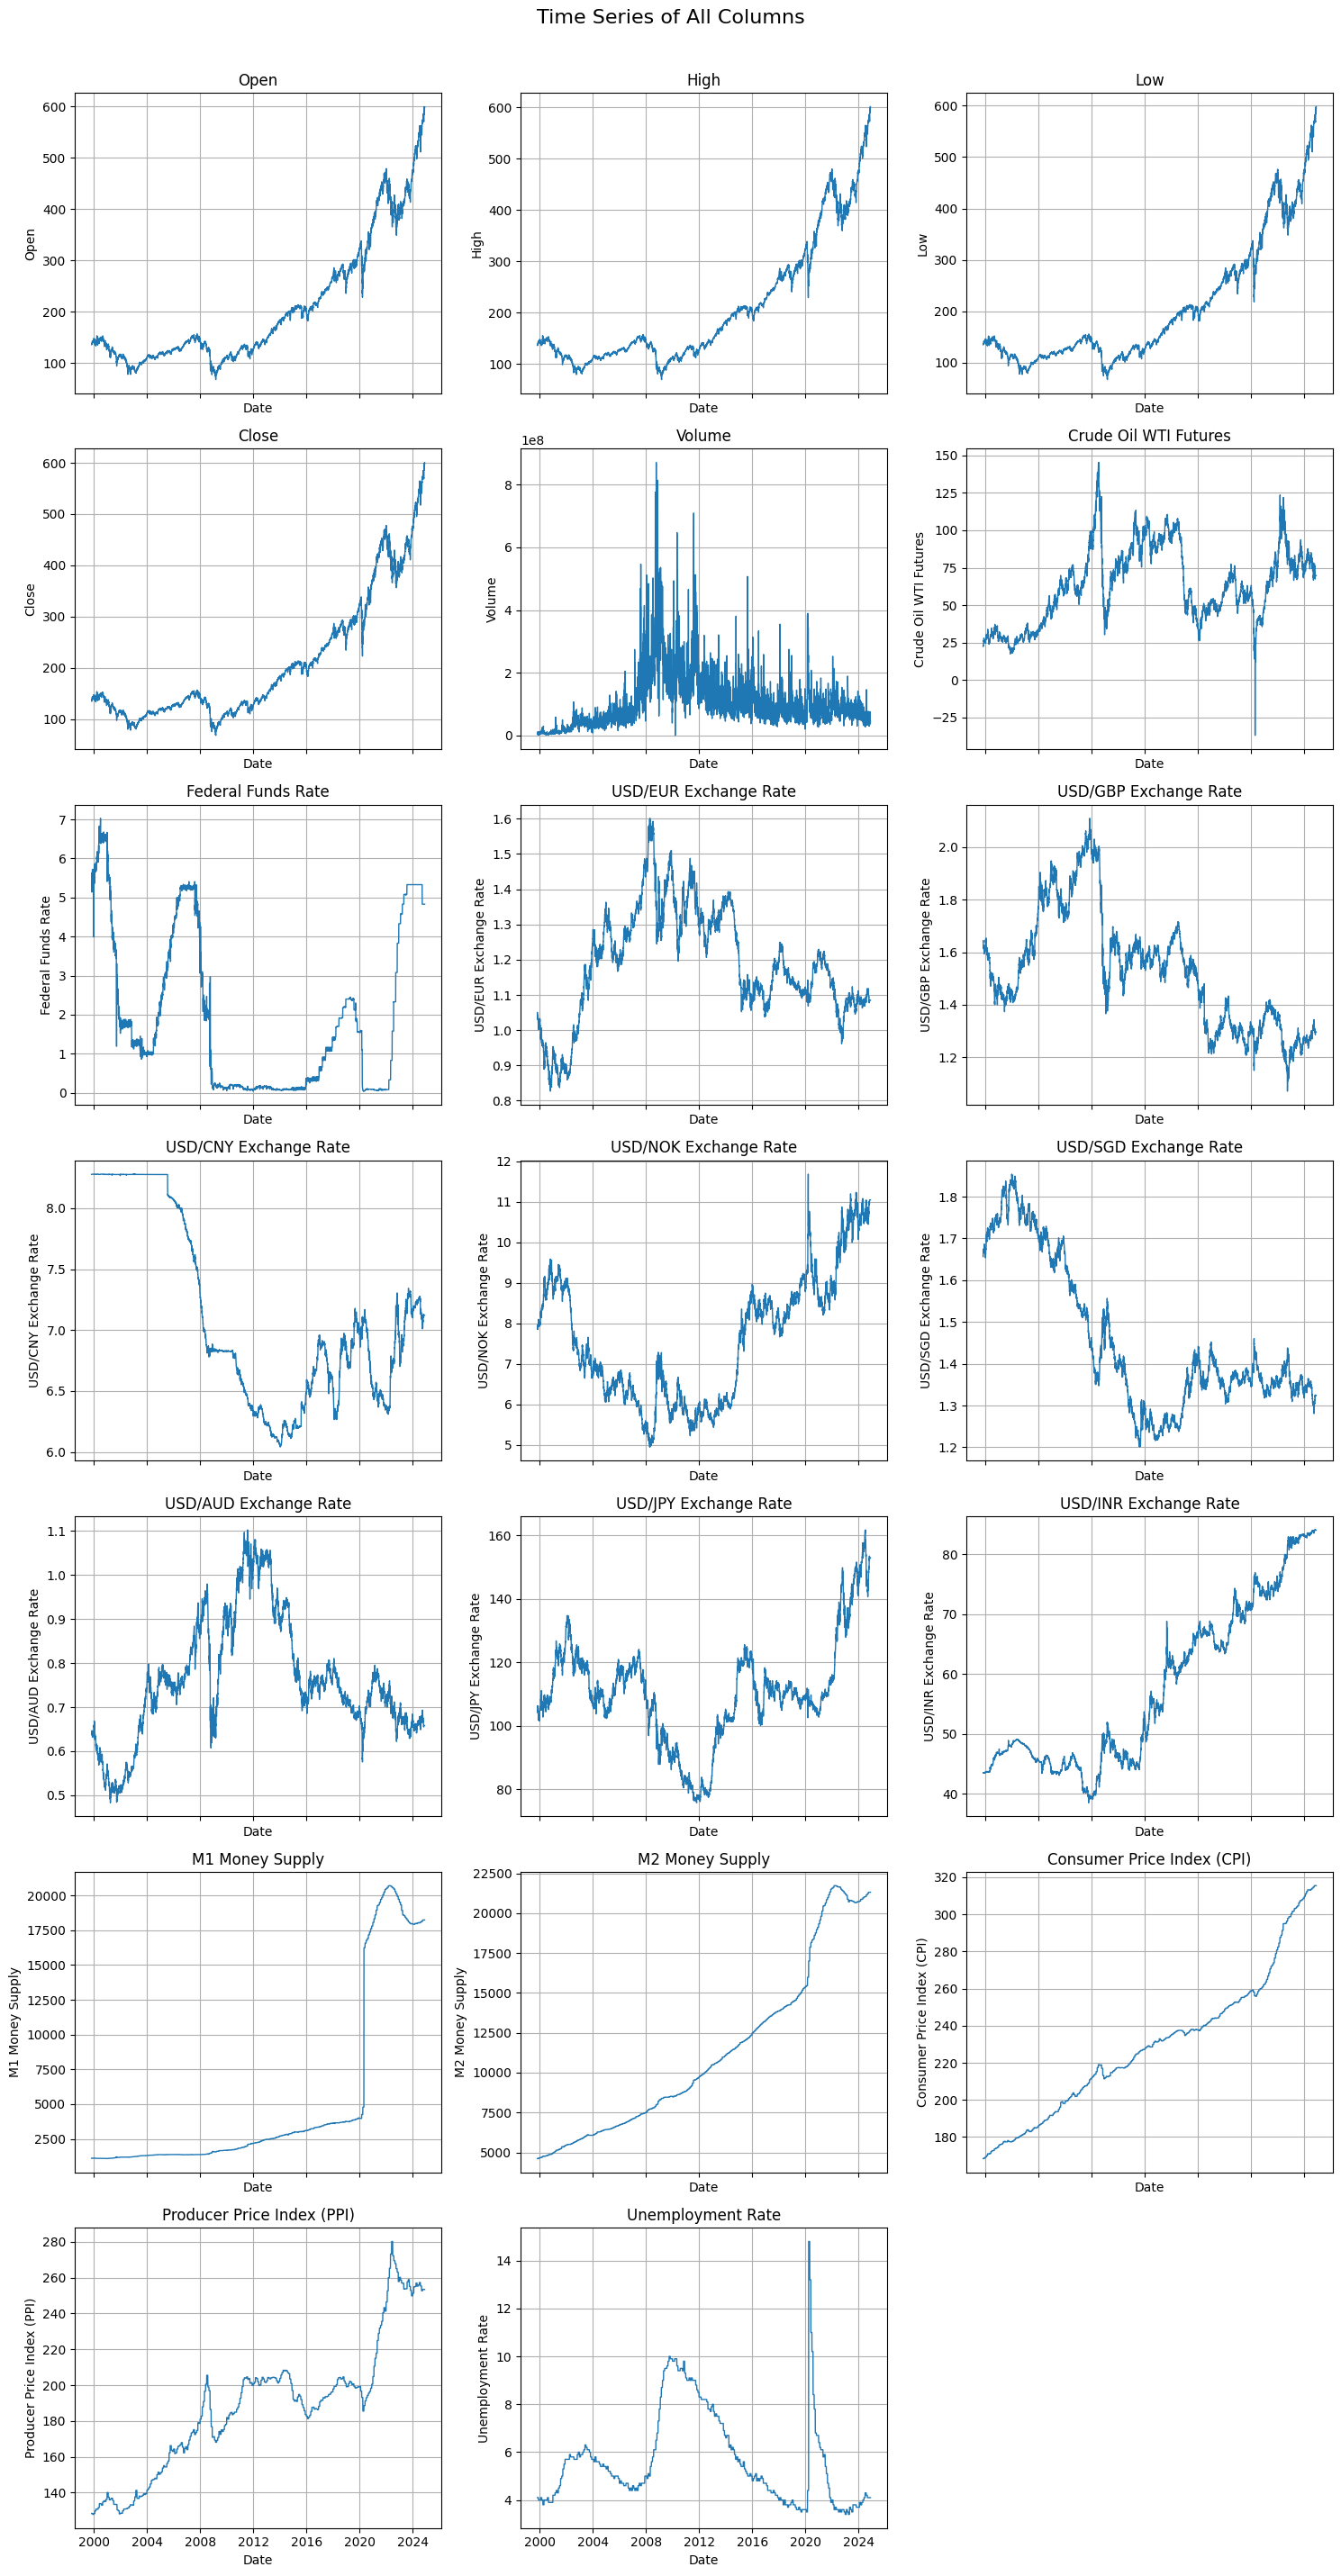

In [16]:
# Determine the number of columns and rows for the grid layout
columns_per_row = 3  # Number of subplots per row
total_columns = [col for col in combined_df.columns if col != 'Date']  # Exclude the 'Date' column
total_plots = len(total_columns)
rows = math.ceil(total_plots / columns_per_row)  # Calculate number of rows needed

# Create the grid layout for subplots
fig, axes = plt.subplots(rows, columns_per_row, figsize=(15, rows * 4), sharex=True)
axes = axes.flatten()  # Flatten axes array for easy indexing

# Plot each column in a separate subplot
for i, column in enumerate(total_columns):
    ax = axes[i]
    ax.plot(combined_df['Date'], combined_df[column], linewidth=1)
    ax.set_title(column, fontsize=12)
    ax.set_xlabel("Date", fontsize=10)
    ax.set_ylabel(column, fontsize=10)
    ax.grid(True)

# Remove empty subplots if the number of plots is not a perfect multiple of columns_per_row
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.suptitle("Time Series of All Columns", fontsize=16, y=1.02)  # Add an overall title
plt.show()


In [ ]:
# combined_df.to_csv('combined_df.csv', index=False)

In [146]:
df = combined_df.copy()

# Ensure the data is sorted by date
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

# 1. Candlestick Pattern Classification (13 classes)
eight_trigram_patterns = [
    'BullishHorn', 'BearHorn', 'BullishHigh', 'BearHigh',
    'BullishLow', 'BearLow', 'BullishHarami', 'BearHarami'
]

def classify_eight_trigram(row):
    # Skip the first row as there's no previous day to compare
    if row.name == 0:
        return 'Neutral'

    # Today's and yesterday's high, low, close prices
    ht = row['High']
    lt = row['Low']
    ct = row['Close']

    ht_prev = df.loc[row.name - 1, 'High']
    lt_prev = df.loc[row.name - 1, 'Low']
    ct_prev = df.loc[row.name - 1, 'Close']

    # Apply the eight-trigram conditions
    # 1. BullishHorn
    if (ht > ht_prev) and (lt < lt_prev) and (ct > ct_prev):
        return 'BullishHorn'

    # 2. BearHorn
    elif (ht > ht_prev) and (lt < lt_prev) and (ct < ct_prev):
        return 'BearHorn'

    # 3. BullishHigh
    elif (ht > ht_prev) and (lt > lt_prev) and (ct > ct_prev):
        return 'BullishHigh'

    # 4. BearHigh
    elif (ht > ht_prev) and (lt > lt_prev) and (ct < ct_prev):
        return 'BearHigh'

    # 5. BullishLow
    elif (ht < ht_prev) and (lt < lt_prev) and (ct > ct_prev):
        return 'BullishLow'

    # 6. BearLow
    elif (ht < ht_prev) and (lt < lt_prev) and (ct < ct_prev):
        return 'BearLow'

    # 7. BullishHarami
    elif (ht < ht_prev) and (lt > lt_prev) and (ct > ct_prev):
        return 'BullishHarami'

    # 8. BearHarami
    elif (ht < ht_prev) and (lt > lt_prev) and (ct < ct_prev):
        return 'BearHarami'

    else:
        return 'Neutral'

# Apply the function to classify each row
df['Eight_Trigram_Pattern'] = df.apply(classify_eight_trigram, axis=1)

# Map patterns to numerical codes
df['Eight_Trigram_Code'] = df['Eight_Trigram_Pattern'].map({
    'BullishHorn': 1,
    'BearHorn': 2,
    'BullishHigh': 3,
    'BearHigh': 4,
    'BullishLow': 5,
    'BearLow': 6,
    'BullishHarami': 7,
    'BearHarami': 8,
    'Neutral': 0
})

# 2. Inter-day Price Movement Patterns (Eight-Trigram Scheme)
# Again, we'll use standard definitions due to lack of specifics

def classify_inter_day(row):
    if row.name == 0:
        return 'Neutral'  # No previous day to compare with
    else:
        prev_close = df.loc[row.name - 1, 'Close']
        today_open = row['Open']

        if today_open > prev_close:
            movement = 'Gap Up'
        elif today_open < prev_close:
            movement = 'Gap Down'
        else:
            movement = 'No Gap'

        # Further classification can be added based on High and Low
        return movement



In [147]:
# 1. Custom Functions and Initial Features
df['Inter_Day_Movement'] = df.apply(classify_inter_day, axis=1)
df['Inter_Day_Movement_Code'] = pd.factorize(df['Inter_Day_Movement'])[0]

# 2. Volume Rate of Change
look_back_period = 5  # Adjust based on your analysis needs
df['Volume_ROC'] = df['Volume'].pct_change(periods=n) * 100

# 3. Overlap Indicators
## Simple Moving Averages
df['SMA_5'] = ta.trend.SMAIndicator(close=df['Close'], window=5).sma_indicator()
df['SMA_10'] = ta.trend.SMAIndicator(close=df['Close'], window=10).sma_indicator()
# df['SMA_20'] = ta.trend.SMAIndicator(close=df['Close'], window=20).sma_indicator()
df['SMA_30'] = ta.trend.SMAIndicator(close=df['Close'], window=30).sma_indicator()

## Exponential Moving Averages
df['EMA_10'] = ta.trend.EMAIndicator(close=df['Close'], window=10).ema_indicator()
# df['EMA_20'] = ta.trend.EMAIndicator(close=df['Close'], window=20).ema_indicator()
df['EMA_30'] = ta.trend.EMAIndicator(close=df['Close'], window=30).ema_indicator()

## Double Exponential Moving Average (DEMA)
def calculate_dema(series, window):
    ema = ta.trend.EMAIndicator(close=series, window=window).ema_indicator()
    ema_ema = ta.trend.EMAIndicator(close=ema, window=window).ema_indicator()
    dema = 2 * ema - ema_ema
    return dema

df['DEMA_5'] = calculate_dema(df['Close'], window=5)
df['DEMA_30'] = calculate_dema(df['Close'], window=30)

## Triple Exponential Moving Average (TEMA)
def calculate_tema(series, window):
    ema1 = ta.trend.EMAIndicator(close=series, window=window).ema_indicator()
    ema2 = ta.trend.EMAIndicator(close=ema1, window=window).ema_indicator()
    ema3 = ta.trend.EMAIndicator(close=ema2, window=window).ema_indicator()
    tema = 3 * (ema1 - ema2) + ema3
    return tema

df['TEMA_30'] = calculate_tema(df['Close'], window=30)

## Weighted Moving Average (WMA)
df['WMA_30'] = ta.trend.WMAIndicator(close=df['Close'], window=30).wma()

## Kaufman's Adaptive Moving Average (KAMA)
df['KAMA_5'] = ta.momentum.KAMAIndicator(close=df['Close'], window=5).kama()

## Parabolic SAR
psar = ta.trend.PSARIndicator(high=df['High'], low=df['Low'], close=df['Close'])
df['PSAR'] = psar.psar()

## Bollinger Bands
bb = ta.volatility.BollingerBands(close=df['Close'], window=5, window_dev=2)
df['BB_UPPER'] = bb.bollinger_hband()
df['BB_MIDDLE'] = bb.bollinger_mavg()
df['BB_LOWER'] = bb.bollinger_lband()

# 4. Momentum Indicators
## Average Directional Movement Index (ADX)
df['ADX_10'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=10).adx()
# df['ADX_14'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=14).adx()

## Commodity Channel Index (CCI)
df['CCI_10'] = ta.trend.CCIIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=10).cci()

## Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(close=df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['MACD'] = macd.macd()
df['MACD_SIGNAL'] = macd.macd_signal()
df['MACD_HIST'] = macd.macd_diff()

## Relative Strength Index (RSI)
df['RSI_10'] = ta.momentum.RSIIndicator(close=df['Close'], window=10).rsi()
# df['RSI_14'] = ta.momentum.RSIIndicator(close=df['Close'], window=14).rsi()

## Money Flow Index (MFI)
df['MFI_10'] = ta.volume.MFIIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], window=10).money_flow_index()
# df['MFI_14'] = ta.volume.MFIIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], window=14).money_flow_index()

## Rate of Change (ROC)
df['ROC_10'] = ta.momentum.ROCIndicator(close=df['Close'], window=10).roc()

## Stochastic Oscillator
stoch = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'])
df['STOCH_%K'] = stoch.stoch()
df['STOCH_%D'] = stoch.stoch_signal()

## Williams %R
df['WILLR_10'] = ta.momentum.WilliamsRIndicator(high=df['High'], low=df['Low'], close=df['Close'], lbp=10).williams_r()

## Ultimate Oscillator (ULTOSC)
df['ULTOSC'] = ta.momentum.UltimateOscillator(high=df['High'], low=df['Low'], close=df['Close']).ultimate_oscillator()

# Balance of Power (BOP)
df['BOP'] = (df['Close'] - df['Open']) / (df['High'] - df['Low'])
df['BOP'] = df['BOP'].replace([np.inf, -np.inf], np.nan).fillna(0)

## Chande Momentum Oscillator (CMO)
def calculate_cmo(series, window):
    delta = series.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    sum_gain = gain.rolling(window=window).sum()
    sum_loss = loss.rolling(window=window).sum()
    cmo = 100 * (sum_gain - sum_loss) / (sum_gain + sum_loss)
    return cmo
df['CMO_10'] = calculate_cmo(df['Close'], window=10)

# 5. Volume Indicators
## Accumulation/Distribution Index (ADI
df['ADI'] = ta.volume.AccDistIndexIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume']).acc_dist_index()

## On-Balance Volume (OBV)
df['OBV'] = ta.volume.OnBalanceVolumeIndicator(close=df['Close'], volume=df['Volume']).on_balance_volume()

## Chaikin Money Flow (CMF)
def calculate_chaikin_oscillator(high, low, close, volume, fast_period=3, slow_period=10):
    ad = ta.volume.AccDistIndexIndicator(high=high, low=low, close=close, volume=volume).acc_dist_index()
    ema_fast = ta.trend.EMAIndicator(close=ad, window=fast_period).ema_indicator()
    ema_slow = ta.trend.EMAIndicator(close=ad, window=slow_period).ema_indicator()
    adosc = ema_fast - ema_slow
    return adosc
df['ADOSC'] = calculate_chaikin_oscillator(df['High'], df['Low'], df['Close'], df['Volume'])

# 6. Volatility Indicators
## Average True Range (ATR)
df['ATR_10'] = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=10).average_true_range()
# df['ATR_14'] = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=14).average_true_range()

## Normalized Average True Range (NATR)
df['NATR_10'] = (df['ATR_10'] / df['Close']) * 100
# df['NATR_14'] = (df['ATR_14'] / df['Close']) * 100

## True Range (TRANGE)
def calculate_true_range(high, low, close):
    prev_close = close.shift(1)
    tr = pd.concat([high - low, (high - prev_close).abs(), (low - prev_close).abs()], axis=1).max(axis=1)
    return tr
df['TRANGE'] = calculate_true_range(df['High'], df['Low'], df['Close'])

# 7. Other Indicators
## Average Price
df['AVGPRICE'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4

## Median Price
df['MEDPRICE'] = (df['High'] + df['Low']) / 2

## Typical Price
df['TYPPRICE'] = (df['High'] + df['Low'] + df['Close']) / 3

## Weighted Close Price
df['WCLPRICE'] = (df['High'] + df['Low'] + 2 * df['Close']) / 4

# 8. Lagged Features
# df['Lag_1'] = df['Close'].shift(1)
# df['Lag_2'] = df['Close'].shift(2)

# 9. Returns
df['Return'] = df['Close'].pct_change()

# 10. Rolling Statistics
df['Rolling_Median_10'] = df['Close'].rolling(window=10).median()
df['Rolling_Std_10'] = df['Close'].rolling(window=10).std()
df['Rolling_Median_5'] = df['Close'].rolling(window=5).median()
df['Rolling_Std_5'] = df['Close'].rolling(window=5).std()

# 11. Time-Based Features
df['Day_of_Week'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month

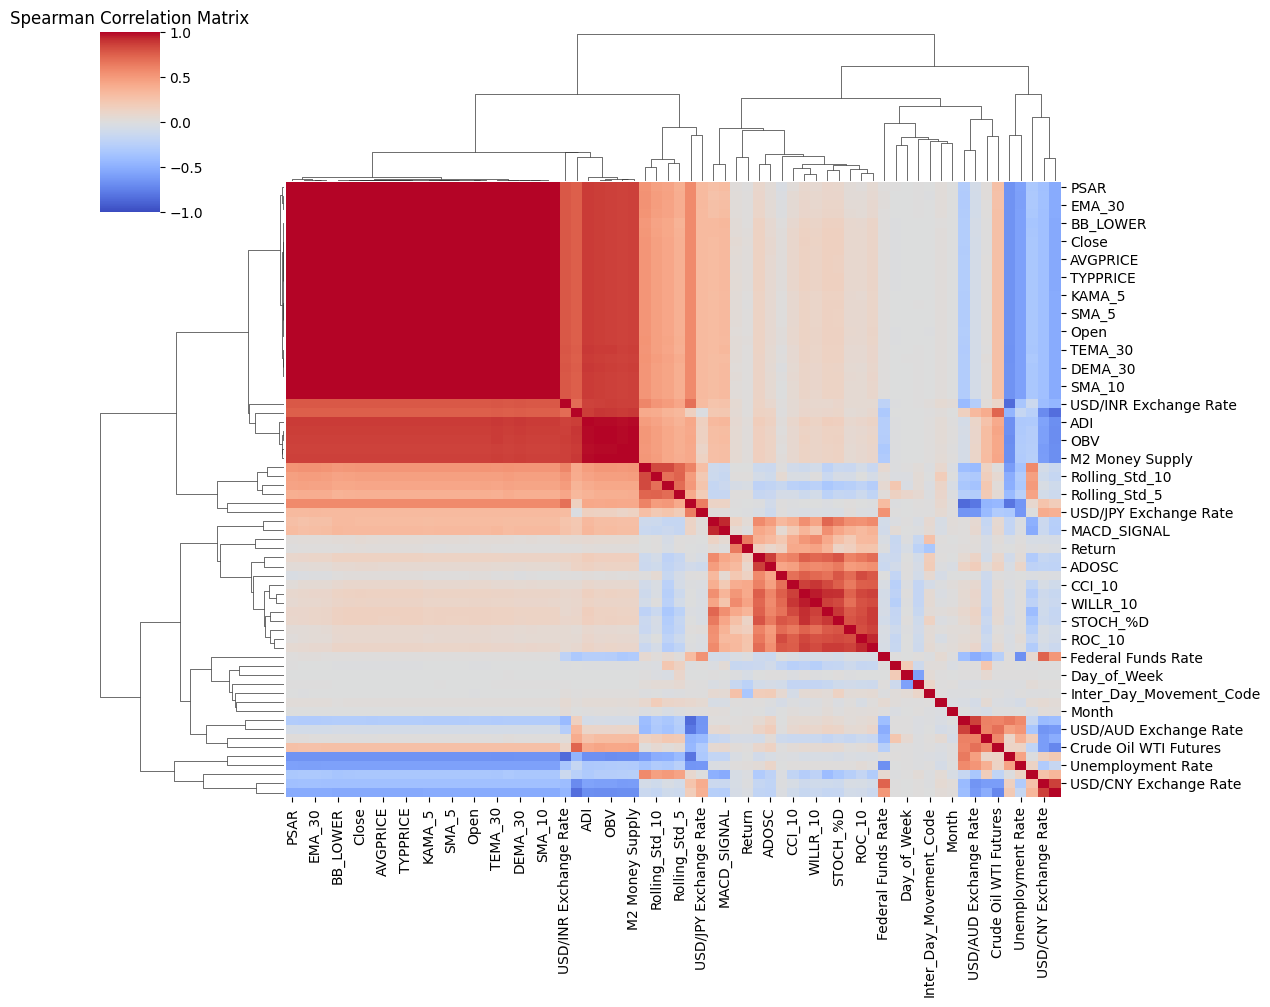

Groups of highly correlated features:
{'Low', 'KAMA_5', 'TEMA_30', 'WCLPRICE', 'EMA_30', 'BB_UPPER', 'Rolling_Median_10', 'SMA_30', 'Close', 'SMA_10', 'High', 'Rolling_Median_5', 'Open', 'BB_LOWER', 'BB_MIDDLE', 'DEMA_30', 'TYPPRICE', 'DEMA_5', 'PSAR', 'SMA_5', 'AVGPRICE', 'WMA_30', 'EMA_10', 'MEDPRICE'}
{'M1 Money Supply', 'Consumer Price Index (CPI)', 'OBV', 'M2 Money Supply', 'ADI'}
{'WILLR_10', 'STOCH_%K'}


In [148]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Calculate the Spearman correlation matrix
corr_matrix = numeric_df.corr(method='spearman')

# Set a threshold for high correlation
threshold = 0.95

# Create a mask to identify highly correlated features
high_corr_var = np.where(np.abs(corr_matrix) > threshold)
high_corr_var = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]

# Create a graph to group highly correlated features
G = nx.Graph()
G.add_edges_from(high_corr_var)

# Find connected components (groups of highly correlated features)
groups = list(nx.connected_components(G))

# Remove one feature from each highly correlated group
features_to_remove = set()
for group in groups:
    features_to_remove.update(list(group)[1:])  # Keep one feature from each group

numeric_df.drop(columns=features_to_remove, inplace=True)

# Visualize the correlation matrix using a clustermap without annotations
sns.clustermap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, figsize=(12, 10))
plt.title('Spearman Correlation Matrix')
plt.show()

# Print the groups of highly correlated features
print("Groups of highly correlated features:")
for group in groups:
    print(group)

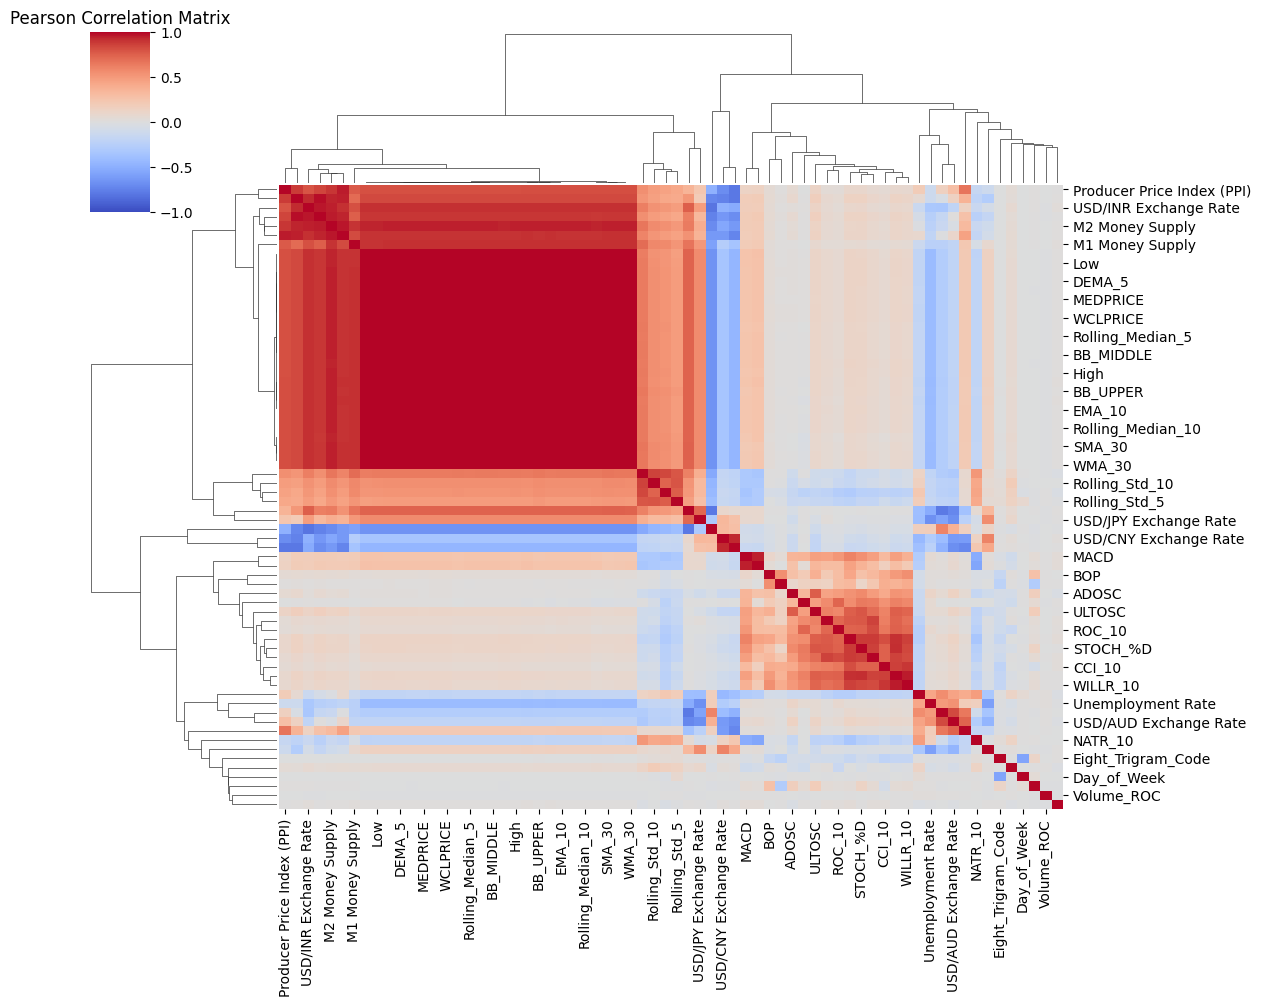

Groups of highly correlated features:
{'Low', 'KAMA_5', 'TEMA_30', 'WCLPRICE', 'EMA_30', 'BB_UPPER', 'Rolling_Median_10', 'SMA_30', 'Close', 'SMA_10', 'High', 'Rolling_Median_5', 'Open', 'BB_LOWER', 'BB_MIDDLE', 'DEMA_30', 'TYPPRICE', 'DEMA_5', 'PSAR', 'SMA_5', 'AVGPRICE', 'WMA_30', 'EMA_10', 'MEDPRICE'}
{'Consumer Price Index (CPI)', 'Producer Price Index (PPI)', 'OBV', 'USD/INR Exchange Rate', 'M2 Money Supply', 'ADI'}
{'MACD_SIGNAL', 'MACD'}
{'WILLR_10', 'STOCH_%K'}


In [149]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Calculate the Spearman correlation matrix
corr_matrix = numeric_df.corr(method='pearson')

# Set a threshold for high correlation
threshold = 0.95

# Create a mask to identify highly correlated features
high_corr_var = np.where(np.abs(corr_matrix) > threshold)
high_corr_var = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]

# Create a graph to group highly correlated features
G = nx.Graph()
G.add_edges_from(high_corr_var)

# Find connected components (groups of highly correlated features)
groups = list(nx.connected_components(G))

# Remove one feature from each highly correlated group
features_to_remove = set()
for group in groups:
    features_to_remove.update(list(group)[1:])  # Keep one feature from each group

numeric_df.drop(columns=features_to_remove, inplace=True)

# Visualize the correlation matrix using a clustermap without annotations
sns.clustermap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, figsize=(12, 10))
plt.title('Pearson Correlation Matrix')
plt.show()

# Print the groups of highly correlated features
print("Groups of highly correlated features:")
for group in groups:
    print(group)

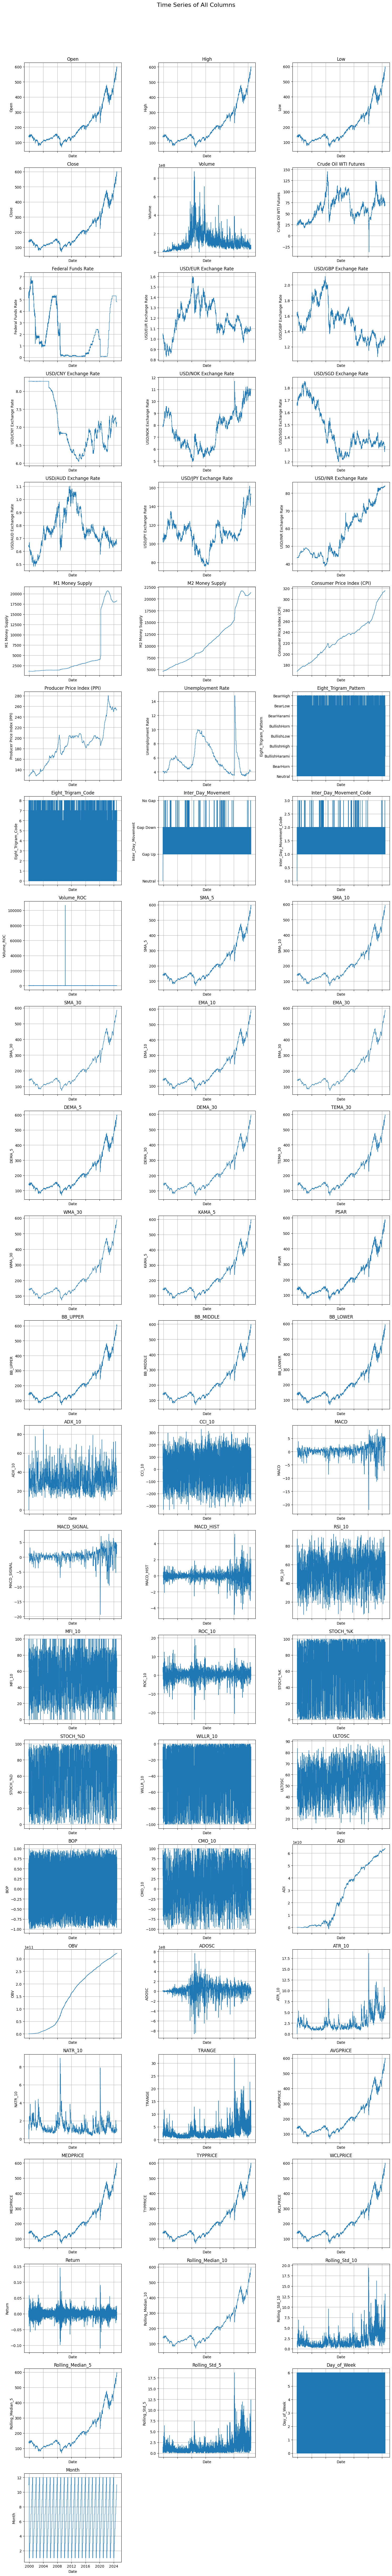

In [101]:
# Determine the number of columns and rows for the grid layout
columns_per_row = 3  # Number of subplots per row
total_columns = [col for col in df.columns if col != 'Date']  # Exclude the 'Date' column
total_plots = len(total_columns)
rows = math.ceil(total_plots / columns_per_row)  # Calculate number of rows needed

# Create the grid layout for subplots
fig, axes = plt.subplots(rows, columns_per_row, figsize=(15, rows * 4), sharex=True)
axes = axes.flatten()  # Flatten axes array for easy indexing

# Plot each column in a separate subplot
for i, column in enumerate(total_columns):
    ax = axes[i]
    ax.plot(df['Date'], df[column], linewidth=1)
    ax.set_title(column, fontsize=12)
    ax.set_xlabel("Date", fontsize=10)
    ax.set_ylabel(column, fontsize=10)
    ax.grid(True)

# Remove empty subplots if the number of plots is not a perfect multiple of columns_per_row
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.suptitle("Time Series of All Columns", fontsize=16, y=1.02)  # Add an overall title
plt.show()


In [ ]:
# Add a small constant to avoid log(0) or log of negative values
epsilon = 1e-10

# Log transformation for numerical columns except 'Close', 'Date', 'Day_of_Week', and 'Month'
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('Close')
numerical_cols.remove('Day_of_Week')
numerical_cols.remove('Month')

# # Check for negative or zero values and shift if necessary
# negative_cols = [col for col in numerical_cols if (df[col] + epsilon <= 0).any()]
# for col in negative_cols:
#     min_val = df[col].min()
#     df[col] = df[col] - min_val + 1  # Shift to make all values positive

# Apply log transformation
df[numerical_cols] = df[numerical_cols].apply(lambda x: np.log1p(x + epsilon))

# Sine and cosine transformation for 'Day_of_Week' and 'Month'
df['Day_of_Week_sin'] = np.sin(2 * np.pi * df['Day_of_Week'] / 7)
df['Day_of_Week_cos'] = np.cos(2 * np.pi * df['Day_of_Week'] / 7)
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
df.drop(['Day_of_Week', 'Month'], axis=1, inplace=True)

# One-hot encoding for categorical columns
categorical_cols = ['Eight_Trigram_Pattern', 'Inter_Day_Movement']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)  # drop_first=True to avoid dummy variable trap

In [162]:
# Check for negative values after log transformation
for col in numerical_cols:
    if (df[col] <= 0).any():
        print(f'Non-positive values found in {col} after log transformation.')


In [144]:
# Handle missing values if any
if df.isnull().values.any():
    df = df.dropna().reset_index(drop=True)

In [152]:
# Time series train-test split
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size].reset_index(drop=True)
test_df = df.iloc[train_size:].reset_index(drop=True)

# Separate features and target
feature_cols = train_df.columns.drop(['Close', 'Date'])
X_train_features = train_df[feature_cols]
X_test_features = test_df[feature_cols]
y_train = train_df['Close'].values
y_test = test_df['Close'].values

# Standardization
scaler = StandardScaler()
scaler.fit(X_train_features)
scaled_X_train = scaler.transform(X_train_features)
scaled_X_test = scaler.transform(X_test_features)

# Convert scaled features back to DataFrame for consistency
scaled_train_df = pd.DataFrame(scaled_X_train, columns=feature_cols)
scaled_train_df['Close'] = y_train
scaled_train_df['Date'] = train_df['Date']

scaled_test_df = pd.DataFrame(scaled_X_test, columns=feature_cols)
scaled_test_df['Close'] = y_test
scaled_test_df['Date'] = test_df['Date']

In [170]:
# Impute monthly data using forward fill
for column in scaled_test_df.columns:
    scaled_test_df[column] = scaled_test_df[column].ffill()

# Impute monthly data using forward fill
for column in scaled_train_df.columns:
    scaled_train_df[column] = scaled_train_df[column].ffill()

In [171]:
# Function to create sequences with date mapping
def create_sequences_with_dates(data, time_steps=10, horizon=1):
    X, y, dates = [], [], []
    for i in range(len(data) - time_steps - horizon + 1):
        X.append(data.iloc[i:(i + time_steps)][feature_cols].values)
        y.append(data['Close'].iloc[i + time_steps + horizon - 1])
        dates.append(data['Date'].iloc[i + time_steps + horizon - 1])
    return np.array(X), np.array(y), np.array(dates)

time_steps = 14  # Number of past days to use for prediction
horizon = 1      # Predict T+1
X_train, y_train, dates_train = create_sequences_with_dates(scaled_train_df, time_steps, horizon)
X_test, y_test, dates_test = create_sequences_with_dates(scaled_test_df, time_steps, horizon)

In [172]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [156]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [173]:
# Define LSTM model with regularization
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h_0, c_0))

        # Get the last time step output
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[2]
hidden_size = 50
output_size = 1
num_layers = 2
dropout = 0.2

model = LSTMModel(input_size, hidden_size, output_size, num_layers, dropout)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
num_epochs = 100
early_stopping_patience = 5
best_loss = float('inf')
patience_counter = 0

In [174]:
# Training loop with validation split
val_size = int(len(train_dataset) * 0.1)
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [len(train_dataset) - val_size, val_size])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

In [175]:
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print('Early stopping')
            break

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

Epoch 1/100, Train Loss: nan, Val Loss: nan
Epoch 2/100, Train Loss: nan, Val Loss: nan
Epoch 3/100, Train Loss: nan, Val Loss: nan
Epoch 4/100, Train Loss: nan, Val Loss: nan
Epoch 5/100, Train Loss: nan, Val Loss: nan
Early stopping


C:\Users\tings\AppData\Local\Temp\ipykernel_30712\1610214438.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


FileNotFoundError: [Errno 2] No such file or directory: 'best_model.pth'

In [176]:
# Check for NaN values in the training features and target
print('NaN in X_train_tensor:', torch.isnan(X_train_tensor).any())
print('NaN in y_train_tensor:', torch.isnan(y_train_tensor).any())

# Check for Infinite values in the training features and target
print('Infinite in X_train_tensor:', torch.isinf(X_train_tensor).any())
print('Infinite in y_train_tensor:', torch.isinf(y_train_tensor).any())

NaN in X_train_tensor: tensor(True)
NaN in y_train_tensor: tensor(False)
Infinite in X_train_tensor: tensor(False)
Infinite in y_train_tensor: tensor(False)


In [177]:
# Identify columns with null values
null_counts = scaled_train_df.isnull().sum()

# Filter only columns with null values
columns_with_nulls = null_counts[null_counts > 0]

print("Columns with null values and their counts:")
print(columns_with_nulls)


Columns with null values and their counts:
Volume_ROC            5
SMA_5                 4
SMA_10                9
SMA_30               29
EMA_10                9
EMA_30               29
DEMA_5                8
DEMA_30              58
TEMA_30              87
WMA_30               29
KAMA_5                4
BB_UPPER              4
BB_MIDDLE             4
BB_LOWER              4
CCI_10                9
MACD                 25
MACD_SIGNAL          33
MACD_HIST            33
RSI_10                9
MFI_10                9
ROC_10               10
STOCH_%K             13
STOCH_%D             15
WILLR_10              9
ULTOSC               28
CMO_10                9
ADOSC                 9
Return                1
Rolling_Median_10     9
Rolling_Std_10        9
Rolling_Median_5      4
Rolling_Std_5         4
dtype: int64


In [169]:
# Identify columns with null values
null_counts = scaled_train_df.isnull().sum()

# Filter only columns with null values
columns_with_nulls = null_counts[null_counts > 0]

print("Columns with null values and their counts:")
print(columns_with_nulls)

Columns with null values and their counts:
Volume_ROC            5
SMA_5                 4
SMA_10                9
SMA_30               29
EMA_10                9
EMA_30               29
DEMA_5                8
DEMA_30              58
TEMA_30              87
WMA_30               29
KAMA_5                4
BB_UPPER              4
BB_MIDDLE             4
BB_LOWER              4
CCI_10                9
MACD                 25
MACD_SIGNAL          33
MACD_HIST            33
RSI_10                9
MFI_10                9
ROC_10               10
STOCH_%K             13
STOCH_%D             15
WILLR_10              9
ULTOSC               28
CMO_10                9
ADOSC                 9
Return                1
Rolling_Median_10     9
Rolling_Std_10        9
Rolling_Median_5      4
Rolling_Std_5         4
dtype: int64


In [ ]:
# Make predictions
model.eval()
train_predictions = []
with torch.no_grad():
    for X_batch, _ in train_loader:
        outputs = model(X_batch)
        train_predictions.extend(outputs.squeeze().tolist())

test_predictions = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        outputs = model(X_batch)
        test_predictions.extend(outputs.squeeze().tolist())



In [ ]:
# Evaluate performance
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')



In [ ]:
# Prepare data for visualization
test_dates = dates_test  # Dates corresponding to the test predictions
pred_df = pd.DataFrame({
    'Date': test_dates,
    'Actual_Close': y_test,
    'Predicted_Close': test_predictions
})



In [ ]:
# Plot Actual vs Predicted Close Prices
plt.figure(figsize=(14, 7))
plt.plot(pred_df['Date'], pred_df['Actual_Close'], label='Actual Close')
plt.plot(pred_df['Date'], pred_df['Predicted_Close'], label='Predicted Close')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices')
plt.legend()
plt.show()